![RNN](https://github.com/taruntiwarihp/raw_images/blob/master/1_goJVQs-p9kgLODFNyhl9zA.gif?raw=true)
### Outline 
1. Introduce dataset
2. Data Processing - Test-Train split, encoding, visualisation
3. Basic RNN - Testing inference 
4. Evaluation and training 
5. LSTM
6. GRU
7. Batching for sequence models
8. Padding and Packing in PyTorch
9. Training with batched dataset
10. Comparison of performance with batching and on GPU

The Recurrent neural networks are a class of artificial neural networks where the connection between nodes form a directed graph along a temporal sequence. Unlike the feed-forward neural networks, the recurrent neural networks use their internal state memory for processing sequences. This dynamic behavior of the Recurrent neural networks allows them to be very useful and applicable to audio analysis, handwritten recognition, and several such applications.
#### Simple RNN implementation.
Mathematically the simple RNN can be formulated as follows:

Where x(t) and y(t) are the input and output vectors, Wᵢ, W, and W are the weight matrices and f and f are the hidden and output unit activation functions.

In [1]:
from io import open 
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim

In [4]:
from IPython.display import clear_output

More reading stuff
1. [here](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks).
2. [here](http://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573).

### Dataset

In [5]:
languages = []
data = []
X = []
y = []

url = '../input/peta-data/data.txt'

with open(url, 'r') as f:
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))
        
n_languages = len(languages)

In [6]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [7]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


### Train - Test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [9]:
print(X_train)

['Abashkin', 'Gulimov', 'Tzelobenok', 'Funnell', 'Zhui', 'Jukes', 'Togunov', 'Sabbag', 'Kartomyshev', 'Makhnenko', 'Sokolsky', 'Masuno', 'Varela', 'Moffat', 'Bonner', 'Berezovsky', 'Helkvist', 'Thurston', 'Tovstuha', 'Millar', 'Tulintsev', 'Furey', 'Isaenko', 'Kalachev', 'Takecare', 'Newcombe', 'Taku', 'Artibyakin', 'Saifulov', 'Morcos', 'Jagodnikov', 'Halifman', 'Bagaryakoff', 'Pavluhin', 'Mari', 'Awramchik', 'Agaltsov', 'Fisichev', 'Shizuma', 'Yankin', 'Luts', 'Toshitala', 'Germain', 'Botros', 'Poulter', 'Lischenko', 'Porter', 'Melendez', 'Ibu', 'Carr', 'Ursler', 'Aderikhin', 'Gimondi', 'Rzhevsky', 'Slater', 'Atkin', 'Yagafarov', 'Huraskin', 'Underhill', 'Pylin', 'Yuschenko', 'Ardovini', 'Tunison', 'Dobrovolsky', 'Bezyzvestnyh', 'Roussel', 'Balakshin', 'Trumbauer', 'Vallance', 'Boerio', 'Waugh', 'Baz', 'Reading', 'Komon', 'Ireson', 'Venables', 'Tikhotsky', 'Spada', 'Winfield', 'Mikhnov', 'Lubsky', 'Antar', 'Sheehan', 'Tuma', 'Yuzefovich', 'Yamburg', 'Yukhvidov', 'Mikhail', 'Chi', 'De

In [10]:
print(len(X_train), len(X_test))

16040 4010


### Encoding names and language

In [11]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [12]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [13]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [14]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype=torch.long)

In [15]:
name_rep('Abreu')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [16]:
lang_rep('Portuguese')

tensor([0])

### Basic Visualisation

In [17]:
count = {}
for l in languages:
    count[l] = 0
for d in data:
    count[d[1]] += 1

In [18]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


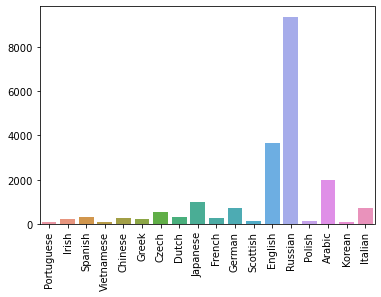

In [19]:
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(),rotation=90)
plt.show()

### Basic Network and testing inference

In [20]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [21]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)

In [22]:
def infer(net, name, device = 'cpu'):
    name_ohe = name_rep(name).to(device)
    
    output, hidden = net(name_ohe)
        
    if type(hidden) is tuple: # For LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)
    
    return output

In [23]:
# output = 
infer(net, 'Adam')
# index = torch.argmax(output)
# print(output, index)

tensor([[-2.9397, -2.8723, -2.8658, -2.9468, -2.8009, -2.8261, -2.8311, -2.9006,
         -3.0482, -2.9506, -3.0368, -2.9434, -2.7790, -2.9250, -2.9422, -2.8976,
         -2.7726, -2.8039]], grad_fn=<LogSoftmaxBackward>)

### Evaluate Model

In [24]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
        
    return to_ret

In [25]:
dataloader(2, X_train, y_train)

[('Lohtin',
  'Russian',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 

In [26]:
def eval(net, n_points, topk, X_, y_, device = 'cpu'):
    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name, device)
        val, indices = output.topk(topk)
        indices = indices.to('cpu')
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [27]:
eval(net, 1000, 1, X_test, y_test)

0.044

### Batching

<img src='https://github.com/taruntiwarihp/raw_images/blob/master/Kuhh0.jpeg?raw=true'>

In [28]:
def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

In [29]:
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps:
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [30]:
out_ = batched_name_rep(['Shyam','Ram'],5)
print(out_)
print(out_.shape)
print_char(out_)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0

In [31]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = languages.index(lang)
    return rep

In [32]:
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
#     print(names_rep, langs_rep)
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted= False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
        
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Reg', langs_rep.data)
        print('Batch sized', padded_names_rep.batch_sizes)
        
    return padded_names_rep.to(device), langs_rep

In [33]:
p, l = batched_dataloader(3, X_train, y_train, True)

torch.Size([7, 3, 57]) torch.Size([18, 57])
--
['Kerper', 'Totah', 'Jakshin']
K
T
J
e
o
a
r
t
k
p
a
s
e
h
h
r
<pad>
i
<pad>
<pad>
n
--
J
K
T
a
e
o
k
r
t
s
p
a
h
e
h
i
r
n
Lang Reg tensor([10, 15, 13])
Batch sized tensor([3, 3, 3, 3, 3, 2, 1])


### Training 
### Basic setup

In [34]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [35]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [36]:
net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [37]:
%%time 
train(net, opt, criterion, 256)

CPU times: user 686 ms, sys: 232 ms, total: 918 ms
Wall time: 1.01 s


tensor(2.9180, grad_fn=<DivBackward0>)

In [38]:
net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [39]:
%%time
train_batch(net, opt, criterion, 256)

CPU times: user 32.8 ms, sys: 1.99 ms, total: 34.8 ms
Wall time: 43.4 ms


tensor(2.8854, grad_fn=<NllLossBackward>)

## Full Training Setup

In [40]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test, device))

### RNN Cell

Iteration 4999 Loss 0.46336811780929565


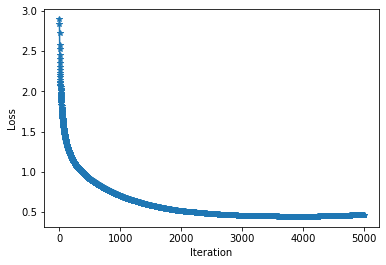




Top-1: 0.7286783042394015 Top-2: 0.8538653366583541
CPU times: user 5min 2s, sys: 16.1 s, total: 5min 18s
Wall time: 5min 19s


In [41]:
%%time
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size= 512, display_freq=500) # CPU Training example

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Iteration 4999 Loss 0.4509669244289398


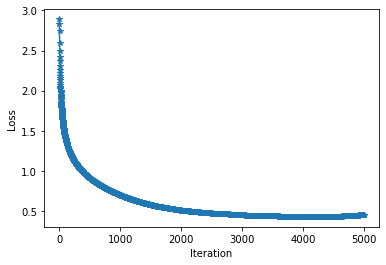




Top-1: 0.7481296758104738 Top-2: 0.8608478802992519
CPU times: user 3min 50s, sys: 1.91 s, total: 3min 51s
Wall time: 3min 54s


In [43]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr= 0.15, n_batches=5000, batch_size = 512, display_freq=100, device=device) # GPU Training Example

### LSTM Cell

In [44]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.lstm_cell(input, hidden)
        output = self.h2o(hidden[0].view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

Iteration 7999 Loss 0.2466673105955124


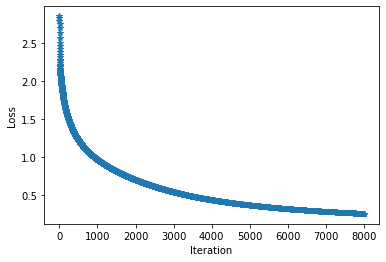




Top-1: 0.7815461346633417 Top-2: 0.8800498753117207


In [45]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device)

### GRU Cell

In [46]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.gru_cell(input, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

Iteration 7999 Loss 0.21910430490970612


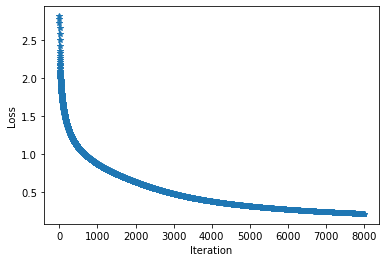




Top-1: 0.8027431421446384 Top-2: 0.8735660847880299
CPU times: user 5min 46s, sys: 1.08 s, total: 5min 48s
Wall time: 5min 48s


In [47]:
%%time
n_hidden = 128
net = GRU_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device)